## Setup

In [2]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import PIL
import pathlib

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.3.0
Hub version: 0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


## Select the TF2 SavedModel module to use

For starters, use [https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4). The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that models in TF1 Hub format won't work here.)

You can find more TF2 models that generate image feature vectors [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2).

There are multiple possible models to try. All you need to do is select a different one on the cell below and follow up with the notebook.

In [3]:
model_name = "mobilenet_v3_small_100_224" # @param ['bit_s-r50x1', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'inception_v3', 'inception_resnet_v2', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152']

model_handle_map = {
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 32 #@param {type:"integer"}

Selected model: mobilenet_v3_small_100_224 : https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5
Input size (224, 224)


## Set up the Flowers dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [7]:
#UNCOMMENT AND RERUN IF YOU CHANGE NETWORKS

In [8]:
# image_height, image_width = IMAGE_SIZE

In [9]:
# import pathlib
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file(origin=dataset_url, 
#                                    fname='flower_photos', 
#                                    untar=True)
# data_dir = pathlib.Path(data_dir)

In [10]:
# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=IMAGE_SIZE,
#   batch_size=1)

In [11]:
# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   image_size=IMAGE_SIZE,
#   batch_size=1)

In [12]:
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [13]:
# np_train_ds = list(tfds.as_numpy(train_ds))
# np_val_ds = list(tfds.as_numpy(val_ds))

# np_train_x = np.empty([2936, 224, 224, 3], dtype=np.float32)
# np_train_y = np.empty([2936], dtype=np.int8)

# np_val_x = np.empty([734, 224, 224, 3], dtype=np.float32)
# np_val_y = np.empty([734], dtype=np.int8)

# for index in range(0,len(np_train_ds)):
#     np_train_x[index] = np_train_ds[index][0][0]
#     np_train_y[index] = np_train_ds[index][1][0]
    
# for index in range(0,len(np_val_ds)):
#     np_val_x[index] = np_val_ds[index][0][0]
#     np_val_y[index] = np_val_ds[index][1][0]


In [14]:
# np.save('data/flower_images_resized_train', np_train_x)
# np.save('data/flower_labels_train', np_train_y)
# np.save('data/flower_images_resized_val', np_val_x)
# np.save('data/flower_labels_val', np_val_y)

In [30]:
np_train_x = np.load('data/flower_images_resized_train.npy')
np_train_y = np.load('data/flower_labels_train.npy')
np_val_x = np.load('data/flower_images_resized_val.npy')
np_val_y = np.load('data/flower_labels_val.npy')

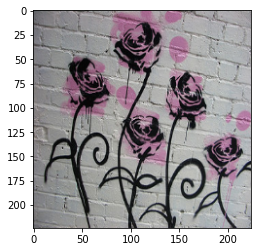

In [31]:
plt.imshow(np_train_x[4]/255.0)
# plt.axis()
plt.show()

In [32]:
np_train_x = np_train_x/255.0
np_val_x = np_val_x/255.0

## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [33]:
do_fine_tuning = False #@param {type:"boolean"}

In [34]:
# print("Building model with", model_handle)
# model = tf.keras.Sequential([
#     # Explicitly define the input shape so the model can be properly
#     # loaded by the TFLiteConverter
#     tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
#     hub.KerasLayer(model_handle, trainable=do_fine_tuning),
#     tf.keras.layers.Dropout(rate=0.2),
#     tf.keras.layers.Dense(train_generator.num_classes,
#                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
# ])
# model.build((None,)+IMAGE_SIZE+(3,))
# model.summary()

In [35]:
def build_model():# Define model layers.
    input_layer = tf.keras.layers.Input(IMAGE_SIZE + (3,))
    keras_hub_layer = hub.KerasLayer(model_handle, trainable=do_fine_tuning)(input_layer)
    dropout_layer = tf.keras.layers.Dropout(rate=0.2)(keras_hub_layer)
    dense_output_layer = tf.keras.layers.Dense(5,
                                               kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                                               name='category_output')(dropout_layer)
    
    # second_dense = Dense(units='128',activation='relu')(first_dense)
    # Y2 output will be fed from the second dense
    check_output_1 = tf.keras.layers.Dense(units='2',
    #                                      kernel_initializer='ones',
    #                                      bias_initializer='zeros',
                                           name='check_output')(dense_output_layer)

    # Define the model with the input layer 
    # and a list of output layers
    return tf.keras.Model(inputs=input_layer, outputs=[dense_output_layer, check_output_1])

In [ ]:
model = build_model()
model.summary()

## Training the model

In [96]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=0.005), 
  loss={'category_output':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
  metrics={'category_output':['SparseCategoricalAccuracy']})

In [97]:
# steps_per_epoch = train_generator.samples // train_generator.batch_size
# validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    x=np_train_x,
    y=np_train_y,
    batch_size=32,
    epochs=20,
    validation_data=(np_val_x, np_val_y)
    ).history

Epoch 1/20


92/92 [==============================] - 71s 774ms/step - loss: 0.4722 - category_output_loss: 0.4705 - category_output_sparse_categorical_accuracy: 0.8215 - val_loss: 0.3427 - val_category_output_loss: 0.3404 - val_category_output_sparse_categorical_accuracy: 0.8801
Epoch 2/20
92/92 [==============================] - 6s 65ms/step - loss: 0.2360 - category_output_loss: 0.2333 - category_output_sparse_categorical_accuracy: 0.9189 - val_loss: 0.3058 - val_category_output_loss: 0.3026 - val_category_output_sparse_categorical_accuracy: 0.8924
Epoch 3/20
92/92 [==============================] - 12s 126ms/step - loss: 0.1793 - category_output_loss: 0.1757 - category_output_sparse_categorical_accuracy: 0.9380 - val_loss: 0.3095 - val_category_output_loss: 0.3054 - val_category_output_sparse_categorical_accuracy: 0.8978
Epoch 4/20
92/92 [==============================] - 4s 41ms/step - loss: 0.1534 - category_output_loss: 0.1489 - category_output_sparse_categorical_accuracy: 0.9499 - val_loss:

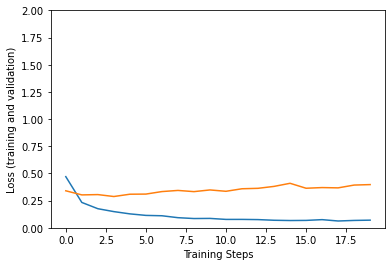

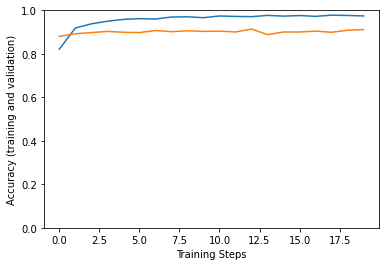

In [98]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["category_output_loss"])
plt.plot(hist["val_category_output_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["category_output_sparse_categorical_accuracy"])
plt.plot(hist["val_category_output_sparse_categorical_accuracy"])

Try out the model on an image from the validation data:

In [89]:
# model.save('saved_models/pretrained_flower_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: saved_models/pretrained_flower_model/assets


INFO:tensorflow:Assets written to: saved_models/pretrained_flower_model/assets


In [4]:
model = tf.keras.models.load_model('saved_models/pretrained_flower_model')

In [5]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1024)              1529968   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
category_output (Dense)      (None, 5)                 5125      
_________________________________________________________________
check_output (Dense)         (None, 2)                 12        
Total params: 1,535,105
Trainable params: 1,522,993
Non-trainable params: 12,112
_________________________________________________________________


In [15]:
model.layers[1].__dict__

{'_self_setattr_tracking': True,
 '_stateful': False,
 '_build_input_shape': None,
 '_saved_model_inputs_spec': None,
 '_input_spec': None,
 '_supports_masking': False,
 '_name': 'keras_layer',
 '_activity_regularizer': None,
 '_trainable_weights': [<tf.Variable 'MobilenetV3/expanded_conv_3/expand/BatchNorm/gamma:0' shape=(96,) dtype=float32, numpy=
  array([ 0.31063017,  3.0967436 ,  3.4726646 ,  1.3473815 ,  2.1998098 ,
          0.8561202 ,  0.62763375,  1.8913414 ,  0.90521735,  1.8509018 ,
          0.6453441 ,  0.61483693,  1.7621634 ,  0.08461449,  2.5078316 ,
          3.4142184 ,  0.14065172,  5.885767  ,  1.5055256 ,  1.7907125 ,
          1.1210032 ,  1.213063  ,  0.3948045 ,  2.146868  ,  1.1209465 ,
          1.2660234 ,  2.0400825 ,  1.7476593 ,  0.8023027 ,  1.6783003 ,
          2.025924  ,  2.784201  ,  0.97810936,  5.386308  ,  0.54625285,
          1.8198057 ,  1.4942061 ,  0.68756646,  0.8991627 ,  0.7377041 ,
          0.57122785,  0.49159974,  0.6726464 ,  0.65905

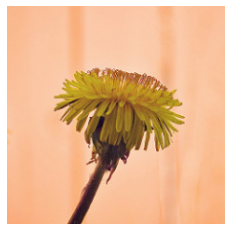

True label: dandelion
Predicted label: tulips


In [20]:
image = np_val_x[21, :, :, :]
true_index = np_val_y[21]
plt.imshow(image)
plt.axis('off')
plt.show()

# # Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_score = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_score[0])
print("True label: " + class_names[int(true_index)])
print("Predicted label: " + class_names[int(predicted_index)])

In [21]:
train_predictions = model.predict(np_train_x)
val_predictions = model.predict(np_val_x)

In [34]:
np.save('results/flower_train_predictions_check', train_predictions[1])
np.save('results/flower_val_predictions_check',  val_predictions[1])

In [23]:
np.save('results/flower_train_predictions', train_predictions[0])
np.save('results/flower_val_predicitons', val_predictions[0])

In [35]:
# TO change/test check network, start here

In [23]:
train_predictions_check_values = np.load('results/flower_train_predictions_check.npy')
val_predictions_check_values = np.load('results/flower_val_predictions_check.npy')

In [38]:
val_predictions_check_values.shape

(734, 2)

## CHECK MODEL DATA PREP

We want our check model to be smaller than the original.
So we need to downsize our input size.
Here, we will be taking our original images and reducing their size

In [4]:
# IMAGE_SIZE = (50,50)

In [5]:
# np_train_x = np.load('data/flower_images_resized_train.npy')
# np_train_y = np.load('data/flower_labels_train.npy')
# np_val_x = np.load('data/flower_images_resized_val.npy')
# np_val_y = np.load('data/flower_labels_val.npy')

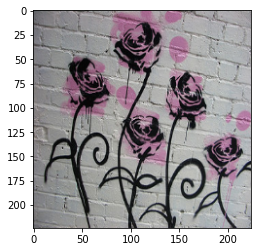

In [6]:
# plt.imshow(np_train_x[4]/255.0)
# # plt.axis()
# plt.show()

In [7]:
# np_train_x_small = tf.image.resize(
#                         np_train_x, IMAGE_SIZE, method='bilinear', preserve_aspect_ratio=False,
#                         antialias=False, name=None
#                     )

# np_val_x_small = tf.image.resize(
#                         np_val_x, IMAGE_SIZE, method='bilinear', preserve_aspect_ratio=False,
#                         antialias=False, name=None
#                     )

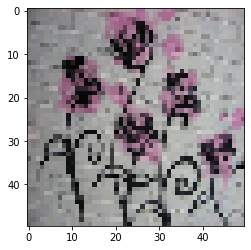

In [8]:
# plt.imshow(np_train_x_small[4]/255.0)
# # plt.axis()
# plt.show()

In [9]:
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [10]:
# np.save('data/flower_images_resized_small_train', np_train_x_small)
# # np.save('data/flower_labels_train', np_train_y)
# np.save('data/flower_images_resized_small_val', np_val_x_small)
# # np.save('data/flower_labels_val', np_val_y)

In [26]:
np_train_x_small = np.load('data/flower_images_resized_small_train.npy')
np_train_y = np.load('data/flower_labels_train.npy')
np_val_x_small = np.load('data/flower_images_resized_small_val.npy')
np_val_y = np.load('data/flower_labels_val.npy')

In [27]:
np_train_x_small = np_train_x_small/255.0
np_val_x_small = np_val_x_small/255.0

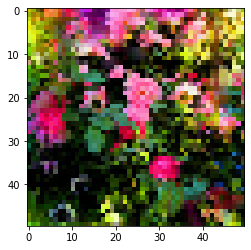

In [28]:
plt.imshow(np_train_x_small[7])
# plt.axis()
plt.show()

In [29]:
# input_layer = tf.keras.layers.Input(shape=(28,28,1))
# conv2d_layer_1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform')(input_layer)
# maxpool_layer_1 = tf.keras.layers.MaxPooling2D((2, 2))(conv2d_layer_1)

### CHECK MODEL 1
This is the first attempt at a check model based on simple combinatorial outputs from the main model
Uses a convnet on a reduced size image

In [30]:
def MAPE(y_true,y_pred): 
    loss = 100 * tf.math.reduce_mean(tf.math.abs((y_true - y_pred) / y_true), axis=-1)
    return loss

In [32]:
model_check = tf.keras.models.Sequential([
                   tf.keras.layers.Conv2D(32, (3,3), input_shape=IMAGE_SIZE + (3,)),
                   tf.keras.layers.MaxPooling2D((2, 2)),
                   tf.keras.layers.Conv2D(32, (3,3)),
                   tf.keras.layers.MaxPooling2D((2, 2)),
                   tf.keras.layers.Conv2D(32, (3,3)),
                   tf.keras.layers.MaxPooling2D((2, 2)),
                   tf.keras.layers.Flatten(),
                   tf.keras.layers.Dense(200,activation='relu'),
                   tf.keras.layers.Dense(2)
               ])
model_check.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=[tf.keras.losses.MeanSquaredError(),tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.Accuracy()],
)

train_stats = model_check.fit(
                x = np_train_x_small,
                y = train_predictions_check_values,
                shuffle=True,
                epochs=100,
                batch_size=32,
                validation_data=(np_val_x_small, val_predictions_check_values),
                verbose=0
              )

In [33]:
model_check.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 52, 52, 32)        9248      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 21632)            

In [45]:
model_check.layers[0].__dict__['_trainable_weights'][0][0][0][0]

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([-0.03118116, -0.10787921,  0.06553699,  0.07921283, -0.10298891,
        0.05025619,  0.12416895, -0.11272132, -0.03666398, -0.06561903,
       -0.10285375, -0.10776681, -0.03966065, -0.00410455,  0.11014596,
       -0.06340927, -0.04550124,  0.07990077, -0.05416697,  0.0402711 ,
       -0.04695106, -0.09111062, -0.02273294,  0.00444265, -0.06974326,
        0.08162098,  0.06092389, -0.06110099,  0.04928294, -0.11911903,
        0.06868158, -0.09974442], dtype=float32)>

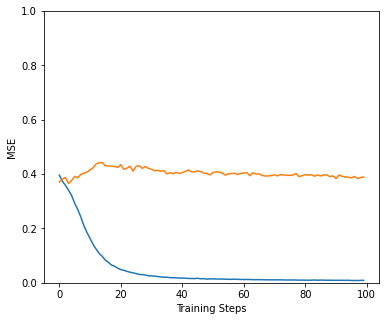

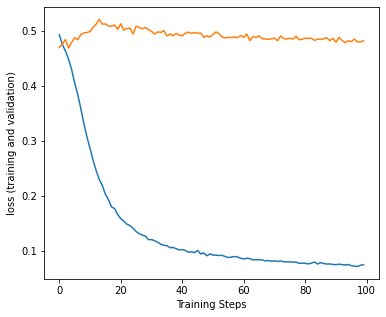

In [229]:
plt.rcParams["figure.figsize"] = (6,5)
plt.figure()
plt.ylabel("MSE")
plt.ylim(0,1)
plt.xlabel("Training Steps")
plt.plot(train_stats.history["mean_squared_error"])
plt.plot(train_stats.history["val_mean_squared_error"])

plt.figure()
plt.ylabel("loss (training and validation)")
plt.xlabel("Training Steps")
plt.plot(train_stats.history["loss"])
plt.plot(train_stats.history["val_loss"])

In [230]:
check_train_predictions = model_check.predict(np_train_x_small)
check_val_predictions = model_check.predict(np_val_x_small)

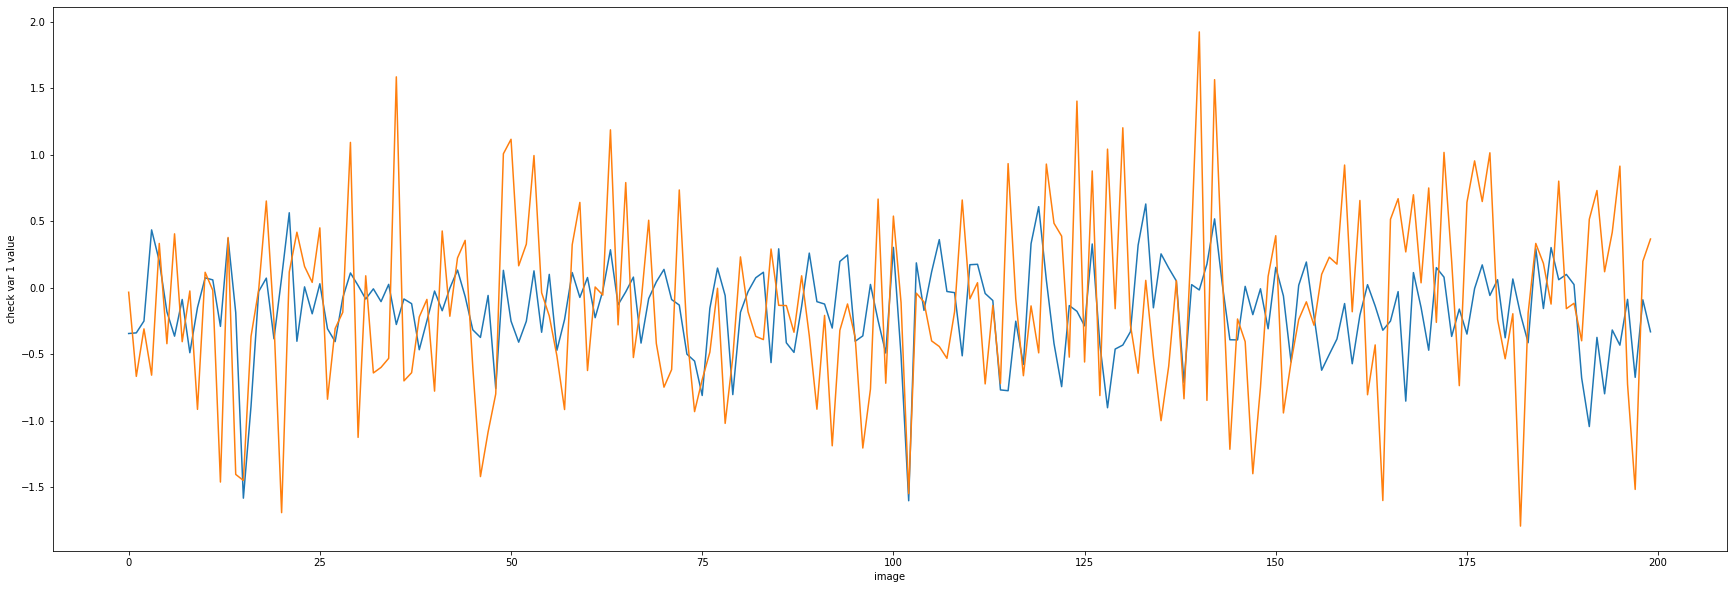

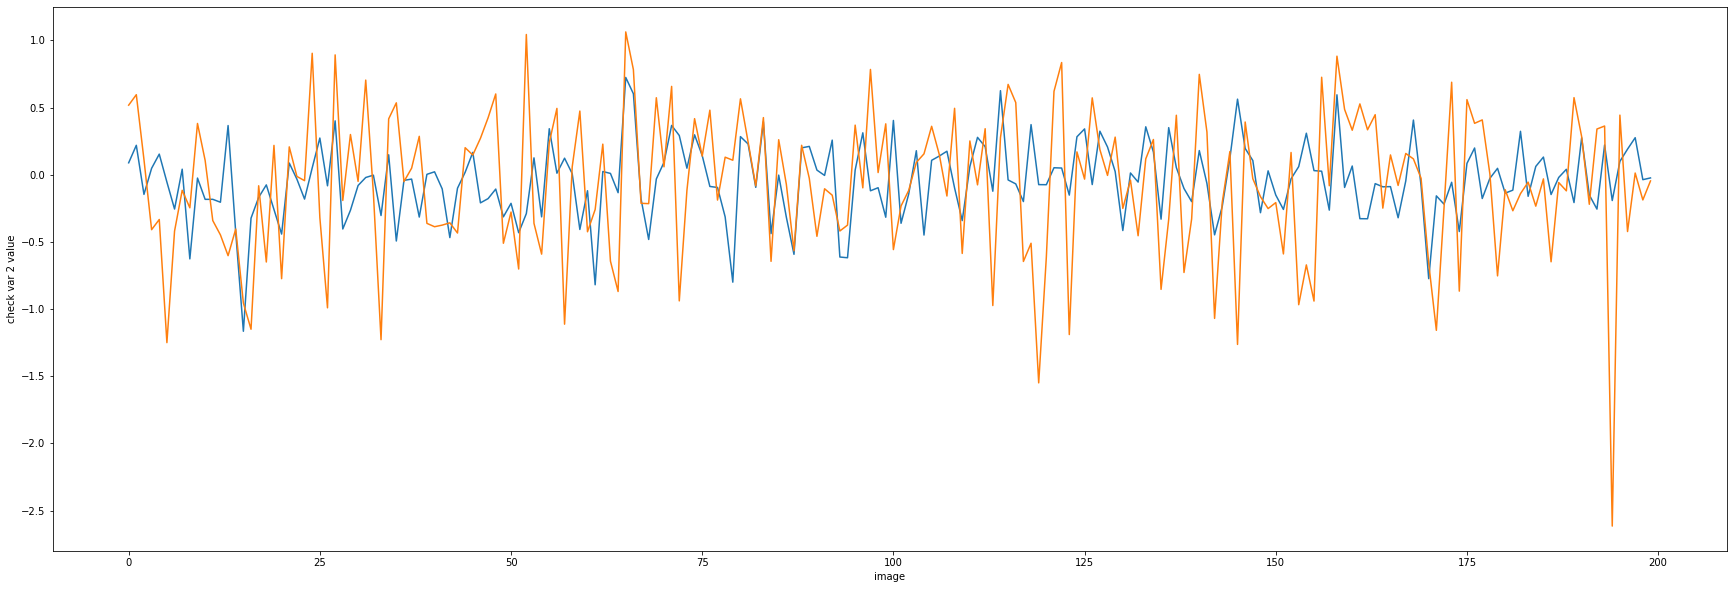

In [231]:
plt.rcParams["figure.figsize"] = (30,10)
plt.figure()
plt.ylabel("check var 1 value")
plt.xlabel("image")
plt.plot(check_val_predictions[:200,1])
plt.plot(val_predictions_check_values[:200,1])

plt.rcParams["figure.figsize"] = (30,10)
plt.figure()
plt.ylabel("check var 2 value")
plt.xlabel("image")
plt.plot(check_val_predictions[:200,0])
plt.plot(val_predictions_check_values[:200, 0])

In [232]:
model_check.evaluate(np_val_x_small, val_predictions_check_values)

23/23 [==============================] - 0s 2ms/step - loss: 0.4824 - mean_squared_error: 0.3894 - mean_absolute_error: 0.4824 - accuracy: 0.0000e+00


[0.482422798871994, 0.3893682360649109, 0.482422798871994, 0.0]

In [233]:
check_val_predictions[:10]

array([[ 0.08832365, -0.3435897 ],
       [ 0.21861821, -0.3386836 ],
       [-0.1466348 , -0.24965078],
       [ 0.04747842,  0.43605477],
       [ 0.15299919,  0.20266303],
       [-0.055069  , -0.1799765 ],
       [-0.25573117, -0.3635087 ],
       [ 0.04081382, -0.0875077 ],
       [-0.62693936, -0.48807353],
       [-0.02532283, -0.14779633]], dtype=float32)

In [234]:
val_predictions_check_values[:10]

array([[ 0.51739126, -0.03314993],
       [ 0.5953942 , -0.6660106 ],
       [ 0.11243589, -0.3087409 ],
       [-0.4094072 , -0.65690076],
       [-0.33362412,  0.33413815],
       [-1.2503296 , -0.4201233 ],
       [-0.42004174,  0.40638652],
       [-0.11639555, -0.40505067],
       [-0.24657954, -0.02350181],
       [ 0.381155  , -0.9141832 ]], dtype=float32)

In [235]:
m = tf.keras.metrics.MeanSquaredError()
m.update_state(check_val_predictions, val_predictions_check_values)
m.result().numpy()

0.38931054

In [236]:
m = tf.keras.metrics.MeanAbsolutePercentageError()
m.update_state(check_val_predictions, val_predictions_check_values)
m.result().numpy()

891.62396

#### Summary
These results are pretty bad

Maybe its because the model is pretrained on imagenet or whatever

and the check_model is only trained on the flower data.


### Check model 2
train output of original model into an autoencoder to get latent space.
Then try to train on latent space in check model?
This isn't going to work

In [24]:
model_train_predictions = np.load('results/flower_train_predictions.npy')
model_val_predictions = np.load('results/flower_val_predicitons.npy')

In [ ]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [25]:
model_check.summary()

NameError: name 'model_check' is not defined